In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
transform = transforms.ToTensor()

In [5]:
train_set = datasets.MNIST(root='./Data',train=True, download=True, transform=transform)

In [6]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [7]:
test_set = datasets.MNIST(root='./Data', train=False, download=True, transform=transform)

In [8]:
test_set

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [9]:
img, label = train_set[0]

In [10]:
img.shape  # 1 stands for grayscale image

torch.Size([1, 28, 28])

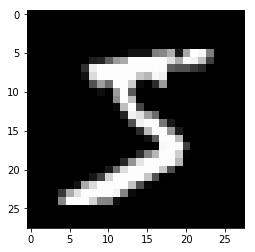

In [11]:
plt.imshow(img.reshape((28,28)), cmap='gray')

In [12]:
torch.manual_seed(101)

In [13]:
train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = DataLoader(test_set, batch_size=500, shuffle=False)

In [14]:
class ANN(nn.Module):
    """
        Creating neural network architecture
        
        Parameters:
            input_size:  size of image (28*28 in this case)
            output_size: number of output classes (numbers 0-9)
            layers: list that contains number of hidden neurons for each layer (2 hidden layers)
            
        Functions:
            forward: feed-forward nn
    """
    
    def __init__(self, input_size=784, output_size=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(input_size,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],output_size)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
        

In [15]:
torch.manual_seed(101)
model = ANN()
model

ANN(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
for param in model.parameters():
    print(param.numel())  # 105,214 params in total

94080
120
10080
84
840
10


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
import time
start_time = time.time()

epochs = 10

#Trackers
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train to (100,28*28) and remove 
                                               #                                        1 dimension(1 for grayscale)
        loss = criterion(y_pred, y_train)
 
        # Number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Printing results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss and accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test to (500,28*28)

            # Number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss and accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed       

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.28055406  accuracy:  83.040%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.20303483  accuracy:  87.325%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.20227623  accuracy:  89.323%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.14457069  accuracy:  94.560%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.10489681  accuracy:  95.110%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.12034713  accuracy:  95.347%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.11627211  accuracy:  96.530%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.08906290  accuracy:  96.615%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.10235450  accuracy:  96.740%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.05358916  accuracy:  97.475%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.05405060  accuracy:  97.475%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.05676333  accuracy:  97.513%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.13540569  accuracy:  97.945%
epoch:  4  b

In [ ]:
# Visualizing losses

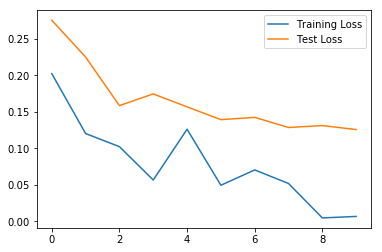

In [19]:
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()

In [20]:
# Test data evaluation

In [21]:
print(test_correct)
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(9449), tensor(9600), tensor(9695), tensor(9709), tensor(9739), tensor(9734), tensor(9764), tensor(9781), tensor(9774), tensor(9775)]

Test accuracy: 97.750%


In [22]:
test_load_all = DataLoader(test_set, batch_size=10000, shuffle=False)

In [23]:
with torch.no_grad():
    
    correct = 0
    
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1)) # flatten X_test to (10000,28*28)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_set)} = {correct.item()*100/(len(test_set)):7.3f}%')

Test accuracy: 9775/10000 =  97.750%


In [24]:
import seaborn as sns

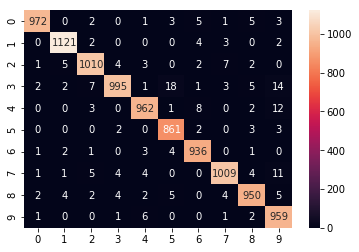

In [25]:
cf_matrix = confusion_matrix(predicted.view(-1), y_test.view(-1)) # view(-1) so it fits for cf matrix visaulization
sns.heatmap(cf_matrix, annot=True,fmt='g')